In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""   # hide all GPUs
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2" # (optional) quieter logs

# (optional) tune CPU threads a bit
os.environ["TF_NUM_INTEROP_THREADS"] = "2"
os.environ["TF_NUM_INTRAOP_THREADS"] = "4"

import tensorflow as tf
print(tf.config.list_physical_devices())        # sanity check
print(tf.config.list_physical_devices('GPU'))   # should be []


2025-09-26 16:40:51.662373: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758894051.673913 1051696 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758894051.676985 1051696 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1758894051.685268 1051696 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1758894051.685285 1051696 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1758894051.685286 1051696 computation_placer.cc:177] computation placer alr

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
[]


2025-09-26 16:40:53.270396: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [2]:
import numpy as np
import math as m
import scipy
from scipy import linalg
import matplotlib.pyplot as plt
#print(Y1)
import tensorflow as tf

# Keras for neural networks
from keras.models import load_model
from keras.layers import Input, Dense, Dropout
from keras.models import Model, load_model
from keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

from tensorflow.keras import layers, models, optimizers

import os
from collections import Counter

# sklearn
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# pandas
import pandas as pd

**We do Hamiltonian learning of a 1D chain that has real onsite energy. We predict the Hamiltonian parameters of the real onsite energies of a single site as a function of spectral density of the same site.
This is done by using a neural network with input dimensions equal to the size of the spectral density of one site and output size = 1.
All the data used in this study is theoretically generated using the functions eigensys and ldos.**

In [3]:
def eigensys(v1): #Hamiltonian of the system of a 1D chain with random real onsite energies
    N = len(v1)
    H1 = np.diag(v1) + np.diag(np.ones(N-1), k=1) + np.diag(np.ones(N-1), k=-1)
    return H1

def ldos(w1, vl1, freq): #spectral density of the system
    dos = np.imag(np.sum(np.conj(vl1)*vl1 / (freq - w1 + 1j*0.05), axis = 1))
    dspp = -dos / np.pi
    return dspp

def visualize_HAM(H_):  #A 2d plot of the real and imaginary parts of the Hamiltonian
    if H_.size < 17:
        print("real:")
        print(H_.real)

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    c0 = ax[0].imshow(H_.real)
    ax[0].set_title("Real part")
    fig.colorbar(c0, ax=ax[0])  

# Generate input data
def input_data(N,f,l):   #Function to generate the input data.
    X0 = np.zeros((N * l, f), dtype=np.float64)  #the spectral density of states of the Hamiltonian
    Y0 = np.zeros((N * l,1), dtype=np.float64)  #the parameters of the Hamiltonian that are to be predicted

    for i in range(l):
        v1 = np.random.uniform(0, 1, N) #random real onsite energy
        H1 = eigensys(v1)  #Hamiltonian of the 1D chain with 8 sites
        w, vl1 = linalg.eigh(H1)  #eigensystem 
        for ip1, freq in enumerate(np.linspace(-2., 2., f)):
            dspp = ldos(w, vl1, freq)  #spectral density for a grid of frequencies for the Hamiltonian
            X0[i * N: (i + 1) * N, ip1] = dspp
        Y0[i * N: (i + 1) * N,0] = v1  #the output vector is saved as (v1) i.e. (real potential)
    return X0, Y0


In [4]:
# Create neural network model
def create_model(input_shape):  #the neural network that predicts v1 and v2 from the corresponding spectral density
    x_input = Input(shape=input_shape, name="x_input")
    x = Dense(300, activation="relu", kernel_initializer="glorot_uniform")(x_input)
    x = Dense(100, activation="relu", kernel_initializer="glorot_uniform")(x)
    x = Dense(50, activation="relu", kernel_initializer="glorot_uniform")(x)
    output = Dense(1)(x)
    model = Model(x_input, output)
    return model

**Generating input date, N is the size of the chain, f is the size of the frequency grid, and l is the sample size, these values can be editted in the next cell**

In [5]:
N=8
f=300
l=1000
X, Y = input_data(N,f,l)  #Generating the input for the training and testing
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)  # Split data into train and test data

In [6]:
model = create_model(input_shape=X_train.shape[1:])  #Defining the neural network 
model.compile(optimizer="adam", loss="mse") #compiling

In [7]:
print(model.summary()) #tracking the training and validation loss of the network
history = model.fit(X_train, y_train, epochs=20, batch_size=16, validation_split=0.2)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ x_input (InputLayer)            │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 300)            │        90,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        30,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 125,501 (490.24 KB)

 Trainable params: 125,501 (490.24 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0647 - val_loss: 0.0166
Epoch 2/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0145 - val_loss: 0.0093
Epoch 3/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0068 - val_loss: 0.0069
Epoch 4/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0050 - val_loss: 0.0040
Epoch 5/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step - loss: 0.0030 - val_loss: 0.0032
Epoch 6/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step - loss: 0.0025 - val_loss: 0.0033
Epoch 7/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0020 - val_loss: 0.0029
Epoch 8/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0015 - val_loss: 0.0022
Epoch 9/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0015 - val_loss: 0.0022
Epoch 10/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0012 - val_loss: 0.0016
Epoch 11/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0012 - val_loss: 0.0019
Epoch 12/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s

In [8]:
loss = model.evaluate(X_test, y_test) #the loss between the true and predicted test data
print("Test Loss:", loss)

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step - loss: 7.3469e-04
Test Loss: 0.0008250881219282746


In [9]:
y_pred_test = model.predict(X_test) #prediction of the test data
y_true_test = y_test
print(y_pred_test.shape) #sanity check
print(y_true_test.shape)

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step
(1600, 1)
(1600, 1)


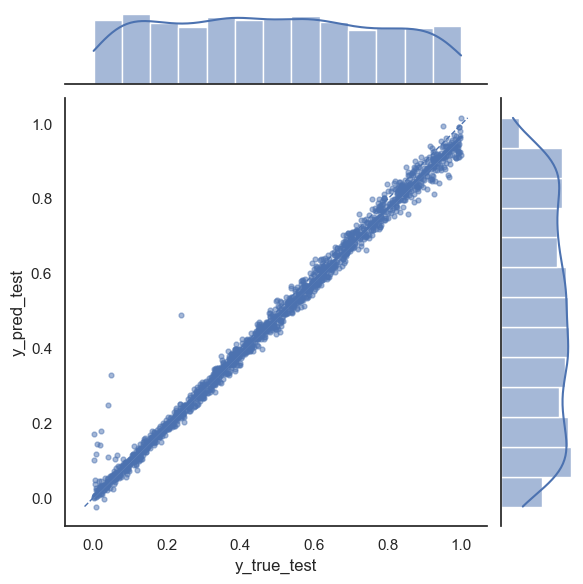

In [10]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# DataFrame
df_pred = pd.DataFrame({
    'y_true_test': y_test.ravel(),
    'y_pred_test': y_pred_test.ravel()
})

# Plot
sns.set(style="white", color_codes=True)
g = sns.jointplot(x='y_true_test', y='y_pred_test', data=df_pred,
                  kind="reg", scatter_kws={'s':12, 'alpha':0.5})

# 45° reference line
ax = g.ax_joint
lo = min(df_pred['y_true_test'].min(), df_pred['y_pred_test'].min())
hi = max(df_pred['y_true_test'].max(), df_pred['y_pred_test'].max())
ax.plot([lo, hi], [lo, hi], linestyle='--', linewidth=1)

# Save
os.makedirs("results", exist_ok=True)
g.fig.savefig("results/pred_vs_true_jointplot_test.png", dpi=300, bbox_inches="tight")

plt.show()


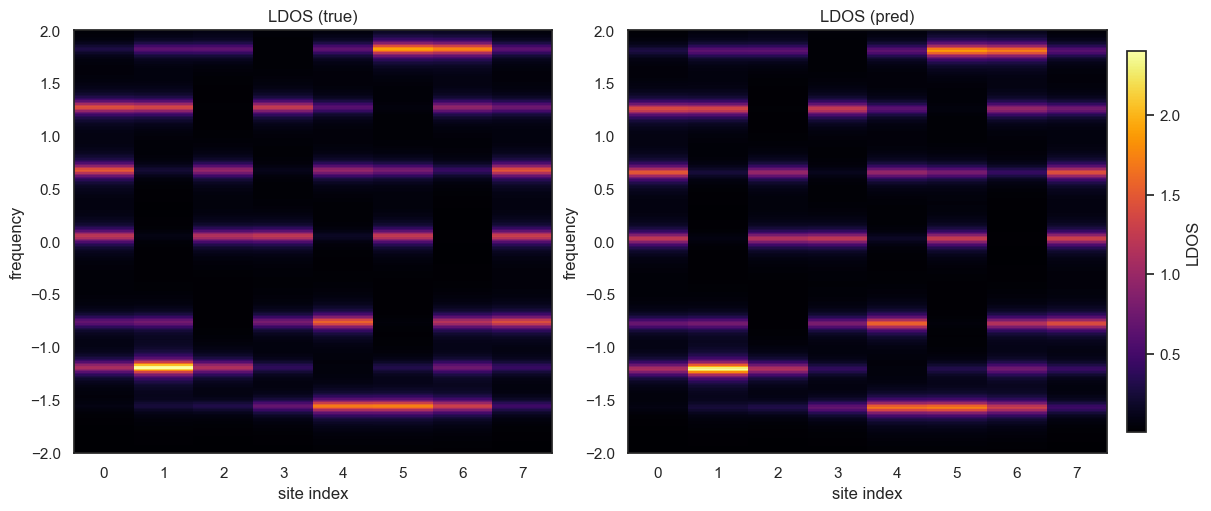

In [11]:
#A visual comparison of the predicted versus the true values, we compute the spectral density 
#of the predicted and true and compare them
N=8
f=300

v11_true = np.asarray(y_true_test[0:N,0]).squeeze()   #true values

H11_true = eigensys(v11_true) 
w_true,vl1_true = linalg.eigh(H11_true)
z_true = np.zeros((f,8),dtype=np.float64)
freqs = np.linspace(-2., 2., f)
for ip1, freq in enumerate(freqs):
     dspp1_true = ldos(w_true,vl1_true,freq)
     z_true[ip1,:] = dspp1_true    
    
##########    
v11_pred = np.asarray(y_pred_test[0:N,0]).squeeze()   #predicted values

H11_pred = eigensys(v11_pred) 
w_pred,vl1_pred = linalg.eigh(H11_pred)
z_pred = np.zeros((f,8),dtype=np.float64)
freqs = np.linspace(-2., 2., f)
for ip1, freq in enumerate(freqs):
     dspp1_pred = ldos(w_pred,vl1_pred,freq)
     z_pred[ip1,:] = dspp1_pred   


# Axes (centers)
x = np.arange(8)          # site indices 0..7
y = freqs                 # shape (f,)

Z_true = z_true           # shape (len(y), len(x))
Z_pred = z_pred           # shape (len(y), len(x))

# Sanity check (optional)
assert Z_true.shape == (len(y), len(x)), f"{Z_true.shape} != ({len(y)}, {len(x)})"
assert Z_pred.shape == (len(y), len(x)), f"{Z_pred.shape} != ({len(y)}, {len(x)})"

# Common color limits for fair comparison
vmin = np.nanmin([Z_true.min(), Z_pred.min()])
vmax = np.nanmax([Z_true.max(), Z_pred.max()])

fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

# Left: TRUE
im0 = axes[0].pcolormesh(x, y, Z_true, shading='nearest', cmap='inferno', vmin=vmin, vmax=vmax)
axes[0].set_xlabel("site index")
axes[0].set_ylabel("frequency")
axes[0].set_title("LDOS (true)")

# Right: PRED
im1 = axes[1].pcolormesh(x, y, Z_pred, shading='nearest', cmap='inferno', vmin=vmin, vmax=vmax)
axes[1].set_xlabel("site index")
axes[1].set_ylabel("frequency")
axes[1].set_title("LDOS (pred)")

# One shared colorbar
cbar = fig.colorbar(im1, ax=axes, location='right', shrink=0.9, pad=0.02)
cbar.set_label("LDOS")
fig.savefig("results/ldos_true_pred1.png", dpi=300, bbox_inches="tight")

plt.show()    




**Now we study the robustness of our neural network in the presence of noise, we do this by adding noise obtained from the normal distribution of different strengths (standard deviation of the normal distribution) and study the Fidelity or correlation between the predicted and true values as a function of this noise strangths**

In [12]:
# Add noise to the data and studying the fidelity versus that noise
def adding_noise(p1, q1, noise_std):  #adding noise to the data from normal distribution
    noise1 = np.random.normal(0, noise_std, size=p1.shape)
    noise2 = np.random.normal(0, noise_std, size=q1.shape)
    p2 = np.concatenate([p1, p1 + noise1], axis=0)
    q2 = np.concatenate([q1, q1 + noise2], axis=0)
    indices = np.arange(len(p2))
    np.random.shuffle(indices)
    return p2[indices], q2[indices]

def fidelity(y_p, y_t): #fidelity i.e. correlation between true and predicted values
    ar = np.array(y_p)
    br = np.array(y_t)
    cr = ar * br
    F = (np.mean(cr) - np.mean(ar) * np.mean(br)) / (
        (np.mean(np.square(ar)) - np.square(np.mean(ar))) *
        (np.mean(np.square(br)) - np.square(np.mean(br)))
        ) ** 0.5    
    return F


Test Loss (noise_std=0.000): 0.000071
Fidelity for noise_std=0.000: Train (0.9997), Test (0.9996)
Test Loss (noise_std=0.022): 0.000599
Fidelity for noise_std=0.022: Train (0.9971), Test (0.9964)
Test Loss (noise_std=0.044): 0.001796
Fidelity for noise_std=0.044: Train (0.9927), Test (0.9893)
Test Loss (noise_std=0.067): 0.003882
Fidelity for noise_std=0.067: Train (0.9846), Test (0.9769)
Test Loss (noise_std=0.089): 0.007404
Fidelity for noise_std=0.089: Train (0.9743), Test (0.9563)
Test Loss (noise_std=0.111): 0.011224
Fidelity for noise_std=0.111: Train (0.9764), Test (0.9336)
Test Loss (noise_std=0.133): 0.015804
Fidelity for noise_std=0.133: Train (0.9648), Test (0.9079)
Test Loss (noise_std=0.156): 0.019542
Fidelity for noise_std=0.156: Train (0.9691), Test (0.8930)
Test Loss (noise_std=0.178): 0.024902
Fidelity for noise_std=0.178: Train (0.9649), Test (0.8623)
Test Loss (noise_std=0.200): 0.032690
Fidelity for noise_std=0.200: Train (0.9410), Test (0.8249)


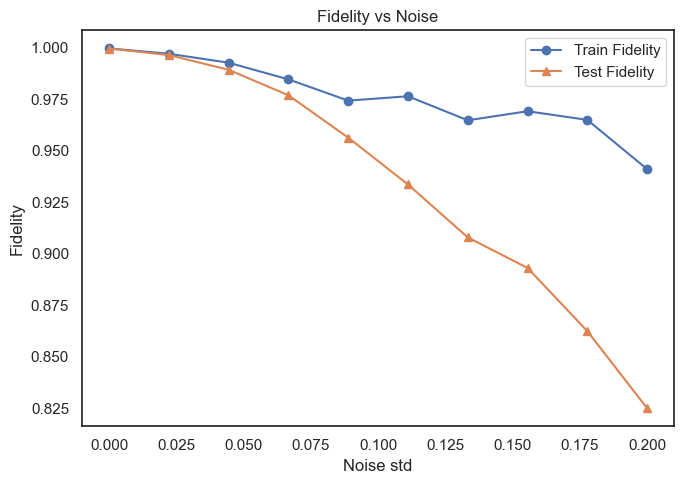

In [13]:
#plot of noise with different standard deviations and comparing the fidelities of different training and testing data


noise_vals = []
F_train_list = []
F_test_list  = []

for noise_std in np.linspace(0.0, 0.2, 10):
    X_train_noise, y_train_noise = adding_noise(X_train, y_train, noise_std) #adding noise
    X_test_noise,  y_test_noise  = adding_noise(X_test,  y_test,  noise_std)

    model = create_model(input_shape=X_train_noise.shape[1:])
    model.compile(optimizer="adam", loss="mse")

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(
        X_train_noise, y_train_noise,
        epochs=20, batch_size=16, validation_split=0.2,
        callbacks=[early_stopping], verbose=0
    )

    loss = model.evaluate(X_test_noise, y_test_noise, verbose=0)  #loss of test
    print(f"Test Loss (noise_std={noise_std:.3f}): {loss:.6f}")

    # Predictions
    y_pred_test_noise  = model.predict(X_test_noise,  verbose=0)
    y_pred_train_noise = model.predict(X_train_noise, verbose=0)

    # Fidelity (robust cast to scalar in case functions return arrays)
    def _as_scalar(x):
        x = np.asarray(x)
        return float(x.mean()) if x.ndim else float(x)

    F_train = _as_scalar(fidelity(y_pred_train_noise, y_train_noise))
    F_test  = _as_scalar(fidelity(y_pred_test_noise,  y_test_noise))

    print(f"Fidelity for noise_std={noise_std:.3f}: "
          f"Train ({F_train:.4f}), "
          f"Test ({F_test:.4f})")

    # Diagnostics (optional)
    # print("Var pred train:", np.var(y_pred_train_noise, axis=0))
    # print("Var pred test :", np.var(y_pred_test_noise,  axis=0))

    # Collect for plotting
    noise_vals.append(noise_std)
    F_train_list.append(F_train)
    F_test_list.append(F_test)

# ---- Plot all fidelities vs noise_std on one chart ----
plt.figure(figsize=(7,5))
plt.plot(noise_vals, F_train_list, marker='o', label='Train Fidelity')
plt.plot(noise_vals, F_test_list,  marker='^', label='Test Fidelity')
plt.xlabel("Noise std")
plt.ylabel("Fidelity")
plt.title("Fidelity vs Noise")
plt.legend()
plt.tight_layout()
fig.savefig("results/fidelityvsnoise_with_overfitting.png", dpi=300, bbox_inches="tight")
plt.show()

# (Optional) Save the figure instead of showing:
# plt.savefig("fidelity_vs_noise.png", dpi=200, bbox_inches="tight")


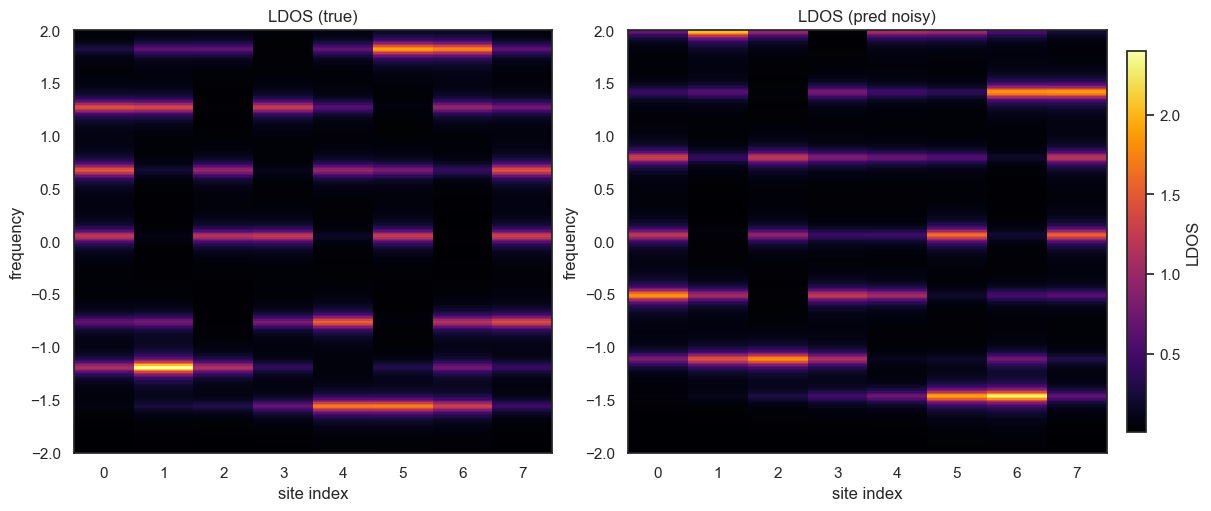

In [14]:
#A visual comparison of the predicted versus the true values, we compute the spectral density 
#of the predicted and true and compare them with noise having noise_std=0.2
v11_pred_noisy = np.asarray(y_pred_test_noise[0:N,0]).squeeze()

H11_pred_noisy = eigensys(v11_pred_noisy) 
w_pred_noisy,vl1_pred_noisy = linalg.eigh(H11_pred_noisy)
z_pred_noisy = np.zeros((f,8),dtype=np.float64)
freqs = np.linspace(-2., 2., f)
for ip1, freq in enumerate(freqs):
     dspp1_pred_noisy = ldos(w_pred_noisy,vl1_pred_noisy,freq)
     z_pred_noisy[ip1,:] = dspp1_pred_noisy 
    


# Axes (centers)
x = np.arange(8)          # site indices 0..7
y = freqs                 # shape (f,)

Z_true = z_true           # shape (len(y), len(x))
Z_pred_noisy = z_pred_noisy           # shape (len(y), len(x))

# Sanity check (optional)
assert Z_true.shape == (len(y), len(x)), f"{Z_true.shape} != ({len(y)}, {len(x)})"
assert Z_pred_noisy.shape == (len(y), len(x)), f"{Z_pred_noisy.shape} != ({len(y)}, {len(x)})"

# Common color limits for fair comparison
vmin = np.nanmin([Z_true.min(), Z_pred_noisy.min()])
vmax = np.nanmax([Z_true.max(), Z_pred_noisy.max()])

fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

# Left: TRUE
im0 = axes[0].pcolormesh(x, y, Z_true, shading='nearest', cmap='inferno', vmin=vmin, vmax=vmax)
axes[0].set_xlabel("site index")
axes[0].set_ylabel("frequency")
axes[0].set_title("LDOS (true)")

# Right: PRED
im1 = axes[1].pcolormesh(x, y, Z_pred_noisy, shading='nearest', cmap='inferno', vmin=vmin, vmax=vmax)
axes[1].set_xlabel("site index")
axes[1].set_ylabel("frequency")
axes[1].set_title("LDOS (pred noisy)")

# One shared colorbar
cbar = fig.colorbar(im1, ax=axes, location='right', shrink=0.9, pad=0.02)
cbar.set_label("LDOS")
fig.savefig("results/ldos_true_pred_noisy_with_overfitting.png", dpi=300, bbox_inches="tight")

plt.show()



**We studied the robustness of our neural network in the presence of noise, but there was an overfitting of our network towards training date, we try to combat this overfitting by twicking the neural network, we do this by adding dropout layers.**

In [15]:
#We see a slight overfitting of the neural network on the training data in the presence of noise, we improve this by 
#using a neural network that has more dropout layers and different learning rates

def create_model_prevent_overfitting(input_shape): #model to prevent overfitting
    # Input layer
    x_input = Input(shape=input_shape, name="x_input")
    # First Dense layer with L2 regularization and Dropout
    x = Dense(300, activation="relu", kernel_initializer="glorot_uniform", 
              kernel_regularizer=l2(0.001))(x_input)
    x = Dropout(0.3)(x)  # Dropout with a rate of 0.3
    # Second Dense layer with L2 regularization and Dropout
    x = Dense(100, activation="relu", kernel_initializer="glorot_uniform", 
              kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.3)(x)  # Dropout with a rate of 0.3
    # Third Dense layer with L2 regularization and Dropout
    x = Dense(50, activation="relu", kernel_initializer="glorot_uniform", 
              kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.3)(x)  # Dropout with a rate of 0.3
    # Output layer
    output = Dense(1)(x)
    # Create and return the model
    model = Model(x_input, output)
    return model

Test Loss (noise_std=0.000): 0.006530
Fidelity for noise_std=0.000: Train (0.9855), Test (0.9848)
Test Loss (noise_std=0.022): 0.007612
Fidelity for noise_std=0.022: Train (0.9855), Test (0.9843)
Test Loss (noise_std=0.044): 0.008354
Fidelity for noise_std=0.044: Train (0.9804), Test (0.9777)
Test Loss (noise_std=0.067): 0.009438
Fidelity for noise_std=0.067: Train (0.9704), Test (0.9685)
Test Loss (noise_std=0.089): 0.012589
Fidelity for noise_std=0.089: Train (0.9570), Test (0.9537)
Test Loss (noise_std=0.111): 0.015528
Fidelity for noise_std=0.111: Train (0.9444), Test (0.9406)
Test Loss (noise_std=0.133): 0.020215
Fidelity for noise_std=0.133: Train (0.9250), Test (0.9180)
Test Loss (noise_std=0.156): 0.025304
Fidelity for noise_std=0.156: Train (0.9001), Test (0.8961)
Test Loss (noise_std=0.178): 0.029787
Fidelity for noise_std=0.178: Train (0.8859), Test (0.8722)
Test Loss (noise_std=0.200): 0.035742
Fidelity for noise_std=0.200: Train (0.8646), Test (0.8458)


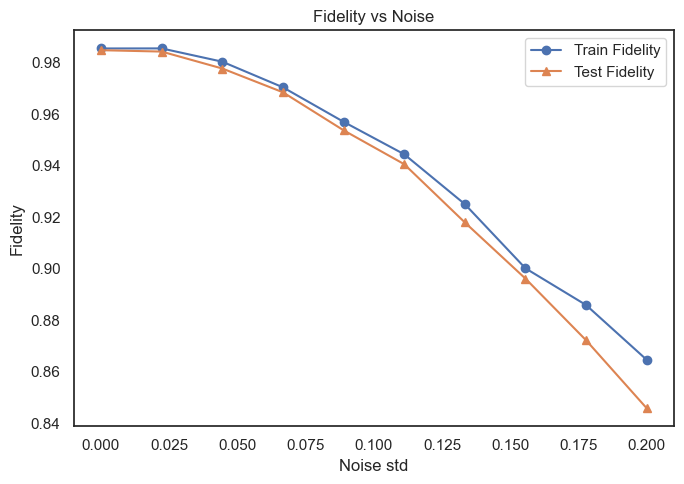

In [16]:
#plot of noise with different standard deviations and comparing the fidelities of different training and testing data
# We see no overfitting here and the fidelity decreases with increase in the strength of noise
import numpy as np
import matplotlib.pyplot as plt

noise_vals = []
F_train_list = []
F_test_list  = []

for noise_std in np.linspace(0.0, 0.2, 10):
    X_train_noise, y_train_noise = adding_noise(X_train, y_train, noise_std) #adding noise
    X_test_noise,  y_test_noise  = adding_noise(X_test,  y_test,  noise_std)

    model = create_model_prevent_overfitting(input_shape=X_train_noise.shape[1:])
    model.compile(optimizer="adam", loss="mse")

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(
        X_train_noise, y_train_noise,
        epochs=20, batch_size=16, validation_split=0.2,
        callbacks=[early_stopping], verbose=0
    )

    loss = model.evaluate(X_test_noise, y_test_noise, verbose=0)  #loss of test
    print(f"Test Loss (noise_std={noise_std:.3f}): {loss:.6f}")

    # Predictions
    y_pred_test_noise1  = model.predict(X_test_noise,  verbose=0)
    y_pred_train_noise1 = model.predict(X_train_noise, verbose=0)

    # Fidelity (robust cast to scalar in case functions return arrays)
    def _as_scalar(x):
        x = np.asarray(x)
        return float(x.mean()) if x.ndim else float(x)

    F_train = _as_scalar(fidelity(y_pred_train_noise1, y_train_noise))
    F_test  = _as_scalar(fidelity(y_pred_test_noise1,  y_test_noise))

    print(f"Fidelity for noise_std={noise_std:.3f}: "
          f"Train ({F_train:.4f}), "
          f"Test ({F_test:.4f})")

    # Diagnostics (optional)
    # print("Var pred train:", np.var(y_pred_train_noise, axis=0))
    # print("Var pred test :", np.var(y_pred_test_noise,  axis=0))

    # Collect for plotting
    noise_vals.append(noise_std)
    F_train_list.append(F_train)
    F_test_list.append(F_test)

# ---- Plot all fidelities vs noise_std on one chart ----
plt.figure(figsize=(7,5))
plt.plot(noise_vals, F_train_list, marker='o', label='Train Fidelity')
plt.plot(noise_vals, F_test_list,  marker='^', label='Test Fidelity')
plt.xlabel("Noise std")
plt.ylabel("Fidelity")
plt.title("Fidelity vs Noise")
plt.legend()
plt.tight_layout()
fig.savefig("results/fidelityvsnoise_nooverfitting.png", dpi=300, bbox_inches="tight")
plt.show()

# (Optional) Save the figure instead of showing:
# plt.savefig("fidelity_vs_noise.png", dpi=200, bbox_inches="tight")


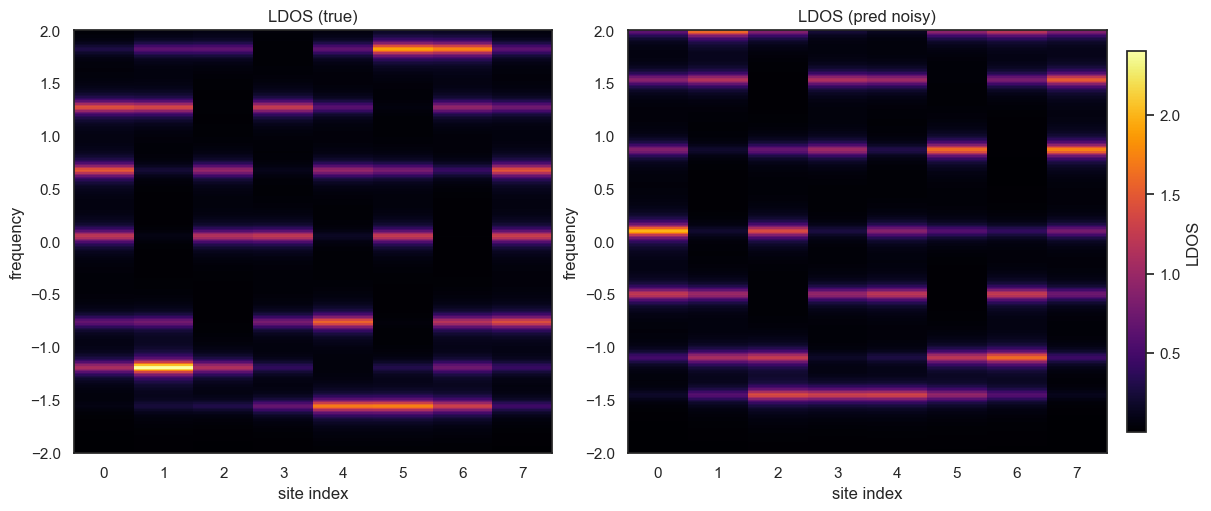

In [17]:
#A visual comparison of the predicted versus the true values, we compute the spectral density 
#of the predicted and true and compare them with noise having noise_std=0.2
v11_pred_noisy = np.asarray(y_pred_test_noise1[0:N,0]).squeeze()

H11_pred_noisy = eigensys(v11_pred_noisy) 
w_pred_noisy,vl1_pred_noisy = linalg.eigh(H11_pred_noisy)
z_pred_noisy1 = np.zeros((f,8),dtype=np.float64)
freqs = np.linspace(-2., 2., f)
for ip1, freq in enumerate(freqs):
     dspp1_pred_noisy = ldos(w_pred_noisy,vl1_pred_noisy,freq)
     z_pred_noisy1[ip1,:] = dspp1_pred_noisy 
    

# Axes (centers)
x = np.arange(8)          # site indices 0..7
y = freqs                 # shape (f,)

Z_true = z_true           # shape (len(y), len(x))
Z_pred_noisy1 = z_pred_noisy1           # shape (len(y), len(x))

# Sanity check (optional)
assert Z_true.shape == (len(y), len(x)), f"{Z_true.shape} != ({len(y)}, {len(x)})"
assert Z_pred_noisy1.shape == (len(y), len(x)), f"{Z_pred_noisy1.shape} != ({len(y)}, {len(x)})"

# Common color limits for fair comparison
vmin = np.nanmin([Z_true.min(), Z_pred_noisy1.min()])
vmax = np.nanmax([Z_true.max(), Z_pred_noisy1.max()])

fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

# Left: TRUE
im0 = axes[0].pcolormesh(x, y, Z_true, shading='nearest', cmap='inferno', vmin=vmin, vmax=vmax)
axes[0].set_xlabel("site index")
axes[0].set_ylabel("frequency")
axes[0].set_title("LDOS (true)")

# Right: PRED
im1 = axes[1].pcolormesh(x, y, Z_pred_noisy1, shading='nearest', cmap='inferno', vmin=vmin, vmax=vmax)
axes[1].set_xlabel("site index")
axes[1].set_ylabel("frequency")
axes[1].set_title("LDOS (pred noisy)")

# One shared colorbar
cbar = fig.colorbar(im1, ax=axes, location='right', shrink=0.9, pad=0.02)
cbar.set_label("LDOS")
fig.savefig("results/ldos_true_pred_noisy_nooverfitting.png", dpi=300, bbox_inches="tight")

plt.show()    

**The end**